## See if the MCTS runs found all the highest-reward structures

In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [3]:
print(np.__version__)
print(pd.__version__)

1.22.3
1.4.2


In [4]:
import nfp
print(nfp.__version__)

2022-06-21 13:02:17.157959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-06-21 13:02:17.157993: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


0.3.12


In [5]:
os.chdir('../')

In [6]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from rlmolecule.crystal.crystal_state import CrystalState

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [7]:
cols = ['id',
        'reward',
        'predicted_energy',
        'decomp_energy',
        'cond_ion_frac',
        'reduction',
        'oxidation',
        'stability_window',
        ]

In [24]:
# rewards_file = "outputs/20220620_rewards/20220621_decors_cond_ion_cutoff_rewards.csv.gz"
rewards_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/2022-06-22-all_decor_rewards.csv.gz"
df = pd.read_csv(rewards_file,
                 names=cols)
print(len(df))
df.head(2)

7698996


,id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,Li1Ti2Ge1Cl1N4|_1_1_1_2_4|orthorhombic|icsd_41...,0.015,0.299,7.325,0.111,NaN,NaN,NaN
1,Li1La1Sb1I3O3|_1_1_1_3_3|monoclinic|icsd_17166...,0.036,-0.391,4.621,0.111,NaN,NaN,NaN


In [25]:
print(len(df[df.reward > .6]))
print(len(df[df.reward > 1]))

34296
7


Text(0.5, 1.0, 'Structures not found by MCTS (7698996)')

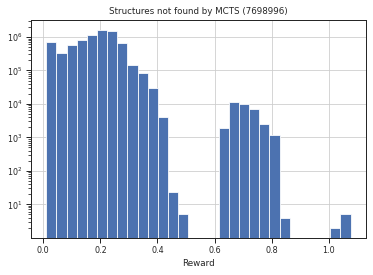

In [46]:
df.reward.hist(bins=30)
plt.yscale("log")
plt.xlabel("Reward")
plt.title(f"Structures not found by MCTS ({len(df)})")

In [27]:
df['comp'] = df.id.apply(lambda x: x.split("|")[0])

In [28]:
df[df.reward >= 1].comp.unique()

array(['K3Sc1Br4I2', 'Li3Sc1Br4I2', 'K3Sc1Br2I4'], dtype=object)

In [44]:
# also load the best decorations
best_decorations_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/batt-icsd-vol-3runs/best_decorations.csv"
df_mcts_best = pd.read_csv(best_decorations_file)
df_mcts_best.head()

,run_id,id,decor_id,comp,reward,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,decomp_energy_s_w,cond_ion_frac_s_w,reduction_s_w,oxidation_s_w,stability_window_s_w,run_id.1
0,20220617-batt-icsd-vol-r90-2,Li3Sc1Br6_icsd_401335_1,Li3Sc1Br6|_1_3_6|trigonal|icsd_401335|1,Li3Sc1Br6,1.118399,-0.7607,0.3000,-0.9753,-5.0000,4.0247,0.640078,0.083333,0.044719,0.055556,0.044719,20220617-batt-icsd-vol-r90-2
1,20220617-batt-icsd-vol-r90-2,Na3Sc1I6_icsd_401335_1,Na3Sc1I6|_1_3_6|trigonal|icsd_401335|1,Na3Sc1I6,1.093755,-0.5759,0.3000,-0.9160,-4.7555,3.8394,0.619544,0.083333,0.045378,0.052839,0.042660,20220617-batt-icsd-vol-r90-2
2,20220617-batt-icsd-vol-r90-2,K5Y1Br8_icsd_262807_1,K5Y1Br8|_1_5_8|triclinic|icsd_262807|1,K5Y1Br8,1.093518,-0.5104,0.3571,-1.5579,-5.0000,3.4421,0.612267,0.099194,0.038246,0.055556,0.038246,20220617-batt-icsd-vol-r90-2
3,20220617-batt-icsd-vol-r90-2,K5Sc1Br8_icsd_262807_1,K5Sc1Br8|_1_5_8|triclinic|icsd_262807|1,K5Sc1Br8,1.088508,-0.4871,0.3571,-1.6667,-5.0000,3.3333,0.609678,0.099194,0.037037,0.055556,0.037037,20220617-batt-icsd-vol-r90-2
4,20220617-batt-icsd-vol-r90-2,Na3Al1Br6_icsd_401335_1,Na3Al1Br6|_1_3_6|trigonal|icsd_401335|1,Na3Al1Br6,1.070164,-0.5054,0.3000,-1.8697,-5.0000,3.1303,0.611711,0.083333,0.034781,0.055556,0.034781,20220617-batt-icsd-vol-r90-2


<AxesSubplot:>

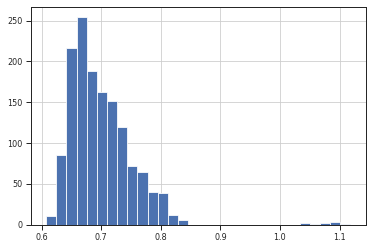

In [45]:
df_mcts_best.reward.hist(bins=30)

In [35]:
comps_missed = set(df[df.reward > .6].comp) - set(df_mcts.comp)
len(comps_missed)

659

In [33]:
df_mcts.comp.nunique()

1344

In [39]:
# see if the search found structures for those compositions
df_mcts = pd.read_csv("/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/batt-icsd-vol-3runs/all_decorations2.csv.gz")
df_mcts.head()

,Unnamed: 0,run_id,decor_id,predicted_energy,decomp_energy,cond_ion_frac,oxidation,reduction,stability_window
0,769644,20220617-batt-icsd-vol-r90-2,Li3Y1Br6|_1_3_6|trigonal|icsd_053533|1,-3.798492,-0.8512,0.3000,-5.0,-0.6734,4.3266
1,7892,20220617-batt-icsd-vol-r90-2,Li4Y1Br7|_1_4_7|cubic|icsd_001322|1,-3.735198,-0.7266,0.3333,-5.0,-0.6045,4.3955
2,1065601,20220617-batt-icsd-vol-r90-2,Li3Y1Br6|_1_3_6|monoclinic|icsd_089617|1,-3.781916,-0.8347,0.3000,-5.0,-0.7286,4.2714
3,913279,20220617-batt-icsd-vol-r90-2,K3Y1Br6|_1_3_6|trigonal|icsd_062035|1,-3.724380,-0.8855,0.3000,-5.0,-0.9881,4.0119
4,43057,20220617-batt-icsd-vol-r90-2,K3Y1Br6|_1_3_6|trigonal|icsd_183024|1,-3.720631,-0.8817,0.3000,-5.0,-1.0006,3.9994


In [42]:
len(df_mcts)

6703705

In [40]:
df_mcts['comp'] = df_mcts.decor_id.apply(lambda x: x.split("|")[0])

83


<AxesSubplot:>

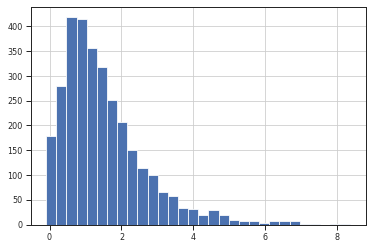

In [43]:
df_mcts_comps_missed = df_mcts[df_mcts.comp.isin(comps_missed)]
print(df_mcts_comps_missed.comp.nunique())
df_mcts_comps_missed.decomp_energy.hist(bins=30)